
**A DQN agent is used to decide whether to scale up, scale down, or take no action.**

1. Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import time
import pickle
import sys
import math
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import traceback

2. Parameters and dataset paths

- Set random seeds for reproducibility. Define Q-learning hyperparameters and file paths

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

LEARNING_RATE = 0.08        
GAMMA = 0.95                
LAMBDA_PARAM = 0.9         
EPS_START = 1.0             
EPS_END = 0.1               
EPS_DECAY = 0.98            
BINS_PER_DIM = 12           

DATA_FILES = {
    'ec2': '../dataset scripts/reduced_ec2_data.csv',
    'rds': '../dataset scripts/reduced_rds_data.csv',
    'ecs': '../dataset scripts/reduced_ecs_data.csv'
}

3. Synthetic data creation

- Generate synthetic EC2, RDS, and ECS data with realistic patterns if data is not available

In [3]:
def create_synthetic_data():
    """Create synthetic data for EC2, RDS, and ECS when real data isn't available."""
    print("Creating synthetic data...")
    synthetic_data = {}
    
    # Create date range for one week with 5-minute intervals
    start_date = datetime(2023, 1, 1)
    end_date = start_date + timedelta(days=7)
    date_range = pd.date_range(start=start_date, end=end_date, freq='5min')
    
    for service in ['ec2', 'rds', 'ecs']:
        df = pd.DataFrame(index=date_range)
        df.index.name = 'timestamp'
        
        # Base pattern with daily cycle and weekly variation
        hour_of_day = df.index.hour
        day_of_week = df.index.dayofweek
        
        # Base CPU pattern
        base_cpu = 30 + 30 * np.sin(np.pi * (hour_of_day - 6) / 12) * (hour_of_day >= 6) * (hour_of_day <= 18)
        
        # Weekend adjustment
        weekend_factor = 0.7 if service == 'ec2' else (0.5 if service == 'rds' else 0.8)
        weekend_mask = (day_of_week >= 5)
        base_cpu[weekend_mask] = base_cpu[weekend_mask] * weekend_factor
        
        # Add noise and spikes
        noise = np.random.normal(0, 8, size=len(df))
        num_spikes = 20
        spike_idx = np.random.choice(len(df), size=num_spikes, replace=False)
        spike_values = np.random.uniform(20, 60, size=num_spikes)
        spike_contributions = np.zeros(len(df))
        spike_contributions[spike_idx] = spike_values
        
        # Combine components
        cpu_values = np.clip(base_cpu + noise + spike_contributions, 0, 100)
        df[f'{service.upper()}_CPUUtilization'] = cpu_values
        
        # Add time features
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        
        # Add service-specific metrics
        if service == 'ec2':
            df['EC2_MemoryUtilization'] = np.clip(0.7 * cpu_values + 0.3 * np.random.normal(50, 10, size=len(df)), 0, 100)
            df['EC2_NetworkIn'] = 100 * (0.5 * cpu_values/100 + 0.5 * np.random.exponential(1, size=len(df)))
            df['EC2_NetworkOut'] = 0.7 * df['EC2_NetworkIn'] + 0.3 * np.random.exponential(100, size=len(df))
            df['EC2_DiskReadOps'] = 50 * (0.3 * cpu_values/100 + 0.7 * np.random.exponential(1, size=len(df)))
            df['EC2_DiskWriteOps'] = 1.5 * df['EC2_DiskReadOps'] + 20 * np.random.exponential(1, size=len(df))
        
        elif service == 'rds':
            df['RDS_FreeableMemory'] = np.clip(1000 * (1 - 0.7 * cpu_values/100 + 0.3 * np.random.normal(0, 0.1, size=len(df))), 100, 1000)
            df['RDS_DatabaseConnections'] = 20 * (0.8 * cpu_values/100 + 0.2 * np.random.exponential(1, size=len(df)))
            df['RDS_ReadIOPS'] = 100 * (0.6 * cpu_values/100 + 0.4 * np.random.exponential(1, size=len(df)))
            df['RDS_WriteIOPS'] = 0.8 * df['RDS_ReadIOPS'] + 10 * np.random.exponential(1, size=len(df))
        
        elif service == 'ecs':
            df['ECS_MemoryUtilization'] = np.clip(0.8 * cpu_values + 0.2 * np.random.normal(60, 15, size=len(df)), 0, 100)
            df['ECS_RunningTaskCount'] = np.clip(np.round(5 + 15 * (cpu_values / 100) + np.random.normal(0, 1, size=len(df))), 1, 50).astype(int)
            df['ECS_NetworkIn'] = 150 * (0.7 * cpu_values/100 + 0.3 * np.random.exponential(1, size=len(df)))
            df['ECS_NetworkOut'] = 0.6 * df['ECS_NetworkIn'] + 50 * np.random.exponential(1, size=len(df))
        
        synthetic_data[service] = df
        file_path = DATA_FILES[service]
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        df.reset_index().to_csv(file_path, index=False)
        print(f"Created synthetic {service} data with {len(df)} rows, saved to {file_path}")
    
    return synthetic_data


3. Load and preprocess data

In [4]:
def load_data(data_files=DATA_FILES):
    data = {}
    files_missing = any(not os.path.exists(file_path) for file_path in data_files.values())
    
    if files_missing:
        data = create_synthetic_data()
    else:
        for service, file_path in data_files.items():
            try:
                df = pd.read_csv(file_path)
                if 'timestamp' in df.columns:
                    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                    df = df.set_index('timestamp')
                
                cpu_col = f"{service.upper()}_CPUUtilization"
                if cpu_col in df.columns:
                    df = df.dropna(subset=[cpu_col])
                    if isinstance(df.index, pd.DatetimeIndex):
                        df['hour'] = df.index.hour
                        df['day_of_week'] = df.index.dayofweek
                    data[service] = df
                    print(f"Loaded {service} data with {len(df)} rows from {file_path}")
                else:
                    print(f"Warning: CPU column {cpu_col} not found in {file_path}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    return data

5. Prioritized Replay Buffer

- Implement a buffer for experience replay with prioritized sampling to improve learning efficiency.

In [5]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha 
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.size = 0
    
    def push(self, state, action, reward, next_state, done):
        max_priority = np.max(self.priorities) if self.size > 0 else 1.0
        
        if self.size < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities[self.size] = max_priority
            self.size += 1
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
        
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if self.size < batch_size:
            return random.sample(self.buffer, self.size), None, None
        
        priorities = self.priorities[:self.size]
        probabilities = priorities ** self.alpha
        probabilities /= np.sum(probabilities)
        
        indices = np.random.choice(self.size, batch_size, p=probabilities, replace=False)
        samples = [self.buffer[idx] for idx in indices]
        
        weights = (self.size * probabilities[indices]) ** (-beta)
        weights /= np.max(weights)  
        
        return samples, indices, weights
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
    
    def __len__(self):
        return self.size

6. Cloud Environment

- Simulate a cloud environment with dynamic resource allocation and a nuanced reward function.

In [6]:
class CloudEnvironment:
    def __init__(self, data, services=['ec2', 'rds', 'ecs']):
        self.data = data if data else {}
        self.services = services
        
        self.cpu_threshold_very_high = 90.0
        self.cpu_threshold_high = 75.0
        self.cpu_threshold_low = 30.0
        self.cpu_threshold_very_low = 15.0
        self.target_cpu_min = 40.0
        self.target_cpu_max = 65.0
        
        self.service_thresholds = {
            'ec2': {'high': 75.0, 'low': 30.0, 'target_min': 40.0, 'target_max': 65.0},
            'rds': {'high': 70.0, 'low': 25.0, 'target_min': 35.0, 'target_max': 60.0},
            'ecs': {'high': 80.0, 'low': 35.0, 'target_min': 45.0, 'target_max': 70.0}
        }
        
        self.cost_per_resource = {'ec2': 1.0, 'rds': 2.5, 'ecs': 0.75}
        
        self.scaling_history = {s: [] for s in services}
        self.historical_cpu = {s: [] for s in services}
        self.historical_memory = {s: [] for s in services}
        
        self.ecs_attributes = {
            'memory_to_cpu_ratio': 1.0,
            'task_characteristics': 0.5,
        }
        
        self.reward_history = []
        self.reward_scale = 1.0
        
        self.reset()

    def reset(self):
        # Reset the environment 
        self.current_step = 0
        self.current_resources = {s: 2 for s in self.services}
        self.current_cpu = {s: 50.0 for s in self.services}
        self.current_memory = {s: 50.0 for s in self.services}
        self.current_hour = 12
        self.current_day = 2
        
        self.scaling_history = {s: [] for s in self.services}
        self.historical_cpu = {s: [] for s in self.services}
        self.historical_memory = {s: [] for s in self.services}
        
        for service in self.services:
            if service in self.data and not self.data[service].empty:
                cpu_col = f"{service.upper()}_CPUUtilization"
                if cpu_col in self.data[service].columns:
                    try:
                        self.current_cpu[service] = self.data[service][cpu_col].iloc[0]
                        if len(self.data[service]) > 10:
                            self.historical_cpu[service] = list(self.data[service][cpu_col].iloc[:10])
                        
                        memory_col = f"{service.upper()}_MemoryUtilization"
                        if memory_col in self.data[service].columns:
                            self.current_memory[service] = self.data[service][memory_col].iloc[0]
                            if len(self.data[service]) > 10:
                                self.historical_memory[service] = list(self.data[service][memory_col].iloc[:10])
                        
                        if service == 'ecs' and 'ECS_RunningTaskCount' in self.data[service].columns:
                            task_count = self.data[service]['ECS_RunningTaskCount'].iloc[0]
                            self.ecs_attributes['task_characteristics'] = min(task_count / 20.0, 1.0)
                        
                        if 'hour' in self.data[service].columns:
                            self.current_hour = self.data[service]['hour'].iloc[0]
                        if 'day_of_week' in self.data[service].columns:
                            self.current_day = self.data[service]['day_of_week'].iloc[0]
                    except Exception:
                        pass
        
        self.update_service_thresholds()
        return self.get_state()

    def update_service_thresholds(self):
        for service in self.services:
            if len(self.historical_cpu[service]) > 20:
                recent_cpu = self.historical_cpu[service][-20:]
                mean_cpu = np.mean(recent_cpu)
                std_cpu = np.std(recent_cpu)
                
                if std_cpu < 5:  
                    self.service_thresholds[service]['target_min'] = max(30, mean_cpu - 10)
                    self.service_thresholds[service]['target_max'] = min(80, mean_cpu + 10)
                else:  
                    self.service_thresholds[service]['target_min'] = max(25, mean_cpu - 15)
                    self.service_thresholds[service]['target_max'] = min(85, mean_cpu + 15)

    def get_state(self):
        # Get the current state
        try:
            state = [
                *[float(self.current_resources[s]) for s in self.services],
                *[float(self.current_cpu[s]) / 100.0 for s in self.services],
                *[float(np.mean(self.historical_cpu[s][-5:])) / 100.0 if len(self.historical_cpu[s]) > 0 
                  else float(self.current_cpu[s]) / 100.0 for s in self.services],
                float(self.current_hour),
                float(self.current_day)
            ]
            
            if 'ecs' in self.services:
                state.append(float(self.ecs_attributes['memory_to_cpu_ratio']))
                state.append(float(self.ecs_attributes['task_characteristics']))
            
            return np.array(state, dtype=np.float32)
        
        except Exception as e:
            print(f"Error in get_state: {e}")
            return np.array([2.0]*3 + [0.5]*6 + [12.0, 2.0], dtype=np.float32)
        finally:
            pass

    def step(self, actions):
        total_reward = 0.0
        info = {
            'step': self.current_step,
            'resources': self.current_resources.copy(),
            'current_cpu': self.current_cpu.copy(),
            'hour': self.current_hour,
            'day': self.current_day,
            'rewards': {}
        }

        try:
            for i, service in enumerate(self.services):
                if i in actions:
                    action = actions[i]
                    old_resources = self.current_resources[service]
                    
                    self.scaling_history[service].append(action)
                    if len(self.scaling_history[service]) > 5:
                        self.scaling_history[service].pop(0)
                    
                    if action == 0 and old_resources > 1:
                        self.current_resources[service] -= 1
                    elif action == 2:
                        self.current_resources[service] += 1
                    
                    self._update_service_metrics(service)
                    
                    utilization = self.current_cpu[service] / max(1, self.current_resources[service])
                    
                    thresholds = self.service_thresholds.get(service, {
                        'high': self.cpu_threshold_high,
                        'low': self.cpu_threshold_low,
                        'target_min': self.target_cpu_min,
                        'target_max': self.target_cpu_max
                    })
                    
                    performance_reward = self._calculate_performance_reward(utilization, thresholds)
                    cost_penalty = -0.4 * self.current_resources[service] * self.cost_per_resource[service]
                    scaling_penalty = self._calculate_scaling_penalty(action, old_resources)
                    protection_bonus = self._calculate_protection_bonus(action, utilization, thresholds)
                    oscillation_penalty = self._calculate_oscillation_penalty(service)
                    
                    service_reward = (
                        performance_reward + 
                        cost_penalty + 
                        scaling_penalty + 
                        protection_bonus + 
                        oscillation_penalty
                    )
                    
                    if service == 'ecs':
                        service_reward += self._calculate_ecs_adjustments()
                    
                    info['rewards'][service] = {
                        'performance': performance_reward,
                        'cost': cost_penalty,
                        'scaling': scaling_penalty,
                        'protection': protection_bonus,
                        'oscillation': oscillation_penalty,
                        'total': service_reward
                    }
                    
                    total_reward += service_reward
            
            self.current_step += 1
            
            if self.current_step % 20 == 0:
                self.update_service_thresholds()
            
            self.reward_history.append(total_reward)
            if len(self.reward_history) > 100:
                self.reward_history.pop(0)
                std = np.std(self.reward_history)
                if std > 0:
                    self.reward_scale = 10.0 / std
        
        except Exception as e:
            print(f"Error in step: {e}")
            traceback.print_exc()
            self.current_step += 1
        
        next_state = self.get_state()
        done = self.current_step >= 100
        
        return next_state, float(total_reward / max(1.0, self.reward_scale)), done, info

    def _update_service_metrics(self, service):
        if service in self.data and not self.data[service].empty:
            cpu_col = f"{service.upper()}_CPUUtilization"
            if cpu_col in self.data[service].columns:
                next_step = min(self.current_step + 1, len(self.data[service]) - 1)
                if 0 <= next_step < len(self.data[service]):
                    try:
                        self.current_cpu[service] = self.data[service][cpu_col].iloc[next_step]
                        
                        if 'hour' in self.data[service].columns:
                            self.current_hour = self.data[service]['hour'].iloc[next_step]
                        if 'day_of_week' in self.data[service].columns:
                            self.current_day = self.data[service]['day_of_week'].iloc[next_step]
                        
                        memory_col = f"{service.upper()}_MemoryUtilization"
                        if memory_col in self.data[service].columns:
                            self.current_memory[service] = self.data[service][memory_col].iloc[next_step]
                        
                        if service == 'ecs':
                            if 'ECS_RunningTaskCount' in self.data[service].columns:
                                task_count = self.data[service]['ECS_RunningTaskCount'].iloc[next_step]
                                self.ecs_attributes['task_characteristics'] = min(task_count / 20.0, 1.0)
                            
                            if memory_col in self.data[service].columns:
                                self.ecs_attributes['memory_to_cpu_ratio'] = (
                                    self.current_memory[service] / max(self.current_cpu[service], 1.0))
                    except Exception:
                        self._simulate_metric_change(service)
                else:
                    self._simulate_metric_change(service)
            else:
                self._simulate_metric_change(service)
        else:
            self._simulate_metric_change(service)
        
        self.historical_cpu[service].append(self.current_cpu[service])
        if len(self.historical_cpu[service]) > 10:
            self.historical_cpu[service].pop(0)
        
        if service in self.current_memory:
            self.historical_memory[service].append(self.current_memory[service])
            if len(self.historical_memory[service]) > 10:
                self.historical_memory[service].pop(0)

    def _simulate_metric_change(self, service):
        self.current_cpu[service] = np.clip(
            self.current_cpu[service] + random.uniform(-5, 5), 0, 100)
        if service in self.current_memory:
            self.current_memory[service] = np.clip(
                self.current_memory[service] + random.uniform(-5, 5), 0, 100)

    def _calculate_performance_reward(self, utilization, thresholds):
        optimal_center = (thresholds['target_min'] + thresholds['target_max']) / 2
        optimal_width = (thresholds['target_max'] - thresholds['target_min']) / 2
        return 15.0 * math.exp(-0.5 * ((utilization - optimal_center)/optimal_width)**2)

    def _calculate_scaling_penalty(self, action, old_resources):
        if action == 0 and old_resources > 1: 
            return -0.8
        elif action == 2: 
            return -1.2
        return 0.0 

    def _calculate_protection_bonus(self, action, utilization, thresholds):
        bonus = 0.0
        
        if utilization > thresholds['high']:
            if action == 2: 
                bonus += 8.0
            elif action == 0: 
                bonus -= 12.0
        
        if utilization < thresholds['low']:
            if action == 0:  
                bonus += 4.0
            elif action == 2: 
                bonus -= 5.0
        
        return bonus

    def _calculate_oscillation_penalty(self, service):
        if len(self.scaling_history[service]) >= 4:
            changes = sum(1 for i in range(3) if self.scaling_history[service][i] != self.scaling_history[service][i+1])
            if changes >= 2:
                return -3.0
        return 0.0

    def _calculate_ecs_adjustments(self):
        adjustment = 0.0
        if len(self.historical_memory['ecs']) > 0:
            memory_util = self.current_memory['ecs'] / max(1, self.current_resources['ecs'])
            if memory_util > 80:
                adjustment -= 2.0
        return adjustment

7. Q-learning Agent

- Define the Q-learning agent with eligibility traces, prioritized replay, and adaptive strategies.

In [7]:
class QAgent:
    def __init__(self, bins_per_dim=6, action_size_per_service=3, num_services=3):
        self.bins_per_dim = bins_per_dim  
        self.action_size_per_service = action_size_per_service
        self.num_services = num_services
        
        self.q_table = defaultdict(float)
        
        self.eligibility_traces = defaultdict(float)
        self.lambda_param = 0.7  
        
        self.epsilon = 0.3  
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99
        self.steps_done = 0
        
        self.initial_lr = 0.08
        self.min_lr = 0.01
        
        self.reward_history = []
        self.epsilon_history = []
        self.loss_history = []
        self.service_states = {i: {} for i in range(num_services)}
        self.action_counts = {i: {0: 0, 1: 0, 2: 0} for i in range(num_services)}
        self.high_cpu_actions = {i: {0: 0, 1: 0, 2: 0} for i in range(num_services)}
        self.service_performance = {i: {'rewards': [], 'actions': []} for i in range(num_services)}
        
        self.service_thresholds = {
            0: {'low': 15, 'high': 85, 'opt_low': 30, 'opt_high': 70},  
            1: {'low': 18, 'high': 80, 'opt_low': 35, 'opt_high': 65},  
            2: {'low': 15, 'high': 85, 'opt_low': 30, 'opt_high': 70} 
        }
        
        self._initialize_q_table()
        
        self.state_action_cache = {}
    
    def _initialize_q_table(self):
        print("Initializing Q-table with guided values...")
        for cpu_level in range(0, 101, 5):  
            for resources in range(1, 11):  
                for service_idx in range(self.num_services):
                    thresholds = self.service_thresholds[service_idx]
                    
                    state_key = (resources, cpu_level, service_idx)
                    
                    if cpu_level >= thresholds['high']:
                        self.q_table[(state_key, 0)] = -20.0  
                        self.q_table[(state_key, 1)] = 0.0    
                        self.q_table[(state_key, 2)] = 20.0   
                    elif cpu_level <= thresholds['low'] and resources > 1:
                        self.q_table[(state_key, 0)] = 10.0   
                        self.q_table[(state_key, 1)] = 0.0    
                        self.q_table[(state_key, 2)] = -10.0 
                    elif cpu_level <= thresholds['low'] and resources <= 1:
                        
                        self.q_table[(state_key, 0)] = -15.0  
                        self.q_table[(state_key, 1)] = 10.0  
                        self.q_table[(state_key, 2)] = -5.0  
                    elif thresholds['opt_low'] <= cpu_level <= thresholds['opt_high']:

                        self.q_table[(state_key, 0)] = -5.0  
                        self.q_table[(state_key, 1)] = 10.0   
                        self.q_table[(state_key, 2)] = -5.0  
                    elif thresholds['opt_high'] < cpu_level < thresholds['high']:

                        self.q_table[(state_key, 0)] = -10.0 
                        self.q_table[(state_key, 1)] = 5.0    
                        self.q_table[(state_key, 2)] = 8.0   
                    else: 

                        if resources > 1:
                            self.q_table[(state_key, 0)] = 8.0    
                            self.q_table[(state_key, 1)] = 5.0
                            self.q_table[(state_key, 2)] = -8.0   
                        else:
                            self.q_table[(state_key, 0)] = -10.0 
                            self.q_table[(state_key, 1)] = 10.0   
                            self.q_table[(state_key, 2)] = -5.0   
        
        print("Q-table initialization complete.")
    
    def get_adaptive_learning_rate(self):
        # Adaptive learning rate function
        lr = max(self.min_lr, self.initial_lr * (0.99 ** (self.steps_done // 300)))
        

        if len(self.reward_history) > 10:
            recent_rewards = self.reward_history[-10:]
            if np.mean(recent_rewards[-3:]) > np.mean(recent_rewards[:7]):
                lr *= 1.05  # Increase if improving
            elif np.mean(recent_rewards[-3:]) < np.mean(recent_rewards[:7]):
                lr *= 0.95  # Decrease if getting worse
        
        return np.clip(lr, self.min_lr, self.initial_lr)
    
    def get_simplified_state(self, state, service_idx):
        try:

            if service_idx < len(state) // 2:
                resources = state[service_idx]
                cpu_util = state[service_idx + 3] * 100  # Denormalize
                

                resources = int(min(round(resources), 10))  # Cap at 10 resources
                cpu_level = int(min(round(cpu_util), 100))  # Cap at 100%
                

                return (resources, cpu_level, service_idx)
            else:

                return (2, 50, service_idx)
        except Exception as e:
            print(f"Error in get_simplified_state: {e}")

            return (2, 50, service_idx)
    
    def get_q_value(self, state_tuple, service_idx, action):
        key = (state_tuple, action)
        return self.q_table[key]
    
    def set_q_value(self, state_tuple, action, value):
        key = (state_tuple, action)
        self.q_table[key] = float(value)
    
    def select_action(self, state):
        try:

            for i in range(self.num_services):
                service_state = {}
                if i < len(state) // 2:
                    service_state['resources'] = state[i]
                    service_state['cpu'] = state[i + 3] * 100 
                    self.service_states[i] = service_state
            

            actions = {}
            

            for i in range(self.num_services):

                cpu_util = self.service_states[i].get('cpu', 50)
                resources = self.service_states[i].get('resources', 2)
                simple_state = self.get_simplified_state(state, i)
                

                thresholds = self.service_thresholds[i]
                

                if random.random() > self.epsilon:

                    if cpu_util >= thresholds['high']:

                        actions[i] = 2
                    elif cpu_util <= thresholds['low'] and resources > 1:

                        actions[i] = 0
                    elif cpu_util <= thresholds['low'] and resources <= 1:

                        actions[i] = 1  # No change
                    elif thresholds['opt_low'] <= cpu_util <= thresholds['opt_high']:

                        actions[i] = 1
                    else:


                        q_values = [self.get_q_value(simple_state, i, a) for a in range(3)]
                        

                        if thresholds['opt_high'] < cpu_util < thresholds['high']:

                            q_values[0] -= 5.0  
                            q_values[2] += (cpu_util - thresholds['opt_high']) / 10.0  
                        elif thresholds['low'] < cpu_util < thresholds['opt_low']:

                            if resources > 1:
                                q_values[0] += (thresholds['opt_low'] - cpu_util) / 10.0 
                                q_values[2] -= 5.0
                        

                        best_action = np.argmax(q_values)
                        actions[i] = best_action
                else:

                    if cpu_util >= thresholds['high']:

                        probs = [0.0, 0.05, 0.95]  
                    elif cpu_util <= thresholds['low'] and resources > 1:

                        probs = [0.95, 0.05, 0.0] 
                    elif thresholds['opt_low'] <= cpu_util <= thresholds['opt_high']:

                        probs = [0.05, 0.9, 0.05]  
                    elif thresholds['opt_high'] < cpu_util < thresholds['high']:

                        scale_factor = (cpu_util - thresholds['opt_high']) / (thresholds['high'] - thresholds['opt_high'])
                        up_prob = 0.3 + 0.6 * scale_factor 
                        probs = [0.0, 1.0 - up_prob, up_prob]  
                    else: 

                        if resources > 1:
                            scale_factor = (thresholds['opt_low'] - cpu_util) / (thresholds['opt_low'] - thresholds['low'])
                            down_prob = 0.3 + 0.6 * scale_factor 
                            probs = [down_prob, 1.0 - down_prob, 0.0]  
                        else:

                            probs = [0.0, 0.9, 0.1]  
                    

                    if resources <= 1:
                        probs[0] = 0.0  

                        total = sum(probs)
                        if total > 0:
                            probs = [p/total for p in probs]
                        else:
                            probs = [0.0, 0.9, 0.1] 
                    

                    action = random.choices([0, 1, 2], weights=probs)[0]
                    actions[i] = action
                

                self.action_counts[i][actions[i]] += 1
                if cpu_util > 80:
                    self.high_cpu_actions[i][actions[i]] += 1
            
            return actions
        
        except Exception as e:
            print(f"Error in select_action: {e}")
            print(traceback.format_exc())

            return {i: 1 for i in range(self.num_services)}
    
    def update_q_table(self, state, actions, reward, next_state):
        try:

            learning_rate = self.get_adaptive_learning_rate()
            

            if np.isnan(reward):
                reward = 0.0
            

            for i in range(self.num_services):
                if i in actions:
                    action = actions[i]
                    

                    simple_state = self.get_simplified_state(state, i)
                    next_simple_state = self.get_simplified_state(next_state, i)
                    

                    cpu_util = self.service_states[i].get('cpu', 50)
                    resources = self.service_states[i].get('resources', 2)
                    thresholds = self.service_thresholds[i]
                    

                    followed_rules = False
                    if cpu_util >= thresholds['high'] and action == 2:

                        followed_rules = True
                    elif cpu_util <= thresholds['low'] and resources > 1 and action == 0:

                        followed_rules = True
                    elif thresholds['opt_low'] <= cpu_util <= thresholds['opt_high'] and action == 1:

                        followed_rules = True
                    

                    effective_reward = reward / self.num_services
                    if followed_rules:

                        effective_reward += 2.0
                    elif (cpu_util >= thresholds['high'] and action == 0) or \
                         (cpu_util <= thresholds['low'] and resources > 1 and action == 2):

                        effective_reward -= 5.0
                    

                    current_q = self.get_q_value(simple_state, i, action)
                    

                    next_q_values = [self.get_q_value(next_simple_state, i, a) for a in range(3)]
                    max_next_q = max(next_q_values)
                    

                    td_error = effective_reward + 0.9 * max_next_q - current_q
                    td_error = np.clip(td_error, -5.0, 5.0)  # Prevent large updates
                    

                    new_q = current_q + learning_rate * td_error
                    

                    if followed_rules:

                        original_rule_value = self.get_initial_q_value(simple_state, i, action)
                        new_q = 0.7 * original_rule_value + 0.3 * new_q
                    

                    if np.isfinite(new_q):
                        self.set_q_value(simple_state, action, new_q)
            

            self.reward_history.append(reward)
        
        except Exception as e:
            print(f"Error in update_q_table: {e}")
            print(traceback.format_exc())
    
    def get_initial_q_value(self, state_tuple, service_idx, action):

        resources, cpu_level, _ = state_tuple
        thresholds = self.service_thresholds[service_idx]
        

        if cpu_level >= thresholds['high']:

            return [-20.0, 0.0, 20.0][action]
        elif cpu_level <= thresholds['low'] and resources > 1:

            return [10.0, 0.0, -10.0][action]
        elif cpu_level <= thresholds['low'] and resources <= 1:

            return [-15.0, 10.0, -5.0][action]
        elif thresholds['opt_low'] <= cpu_level <= thresholds['opt_high']:

            return [-5.0, 10.0, -5.0][action]
        elif thresholds['opt_high'] < cpu_level < thresholds['high']:

            return [-10.0, 5.0, 8.0][action]
        else: 
            if resources > 1:
                return [8.0, 5.0, -8.0][action]
            else:
                return [-10.0, 10.0, -5.0][action]
    
    def update_epsilon(self):

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.epsilon_history.append(self.epsilon)
        self.steps_done += 1
    
    def save_model(self, file_path):
        try:
            model_data = {
                'q_table': dict(self.q_table),
                'epsilon': self.epsilon,
                'reward_history': self.reward_history,
                'epsilon_history': self.epsilon_history,
                'bins_per_dim': self.bins_per_dim,
                'action_size_per_service': self.action_size_per_service,
                'num_services': self.num_services,
                'loss_history': self.loss_history,
                'action_counts': self.action_counts,
                'high_cpu_actions': self.high_cpu_actions,
                'service_performance': self.service_performance,
                'service_thresholds': self.service_thresholds
            }
            
            with open(file_path, 'wb') as f:
                pickle.dump(model_data, f)
            
            print(f"Model saved to {file_path}")
        except Exception as e:
            print(f"Error saving model: {e}")
            print(traceback.format_exc())
    
    def load_model(self, file_path):
        if os.path.exists(file_path):
            try:
                with open(file_path, 'rb') as f:
                    model_data = pickle.load(f)
                
                self.q_table = defaultdict(float, model_data['q_table'])
                self.epsilon = model_data.get('epsilon', self.epsilon_min)
                self.reward_history = model_data.get('reward_history', [])
                self.epsilon_history = model_data.get('epsilon_history', [])
                self.bins_per_dim = model_data.get('bins_per_dim', self.bins_per_dim)
                self.loss_history = model_data.get('loss_history', [])
                self.action_counts = model_data.get('action_counts', 
                                               {i: {0: 0, 1: 0, 2: 0} for i in range(self.num_services)})
                self.high_cpu_actions = model_data.get('high_cpu_actions', 
                                                  {i: {0: 0, 1: 0, 2: 0} for i in range(self.num_services)})
                self.service_performance = model_data.get('service_performance',
                                                     {i: {'rewards': [], 'actions': []} for i in range(self.num_services)})
                self.service_thresholds = model_data.get('service_thresholds', self.service_thresholds)
                
                print(f"Model loaded from {file_path}")
                return True
            except Exception as e:
                print(f"Error loading model: {e}")
                print(traceback.format_exc())
                return False
        return False

8. Training Function

In [ ]:
def train_agent(env, agent, num_episodes=50, save_path='cloud_dqn.pkl', save_best=True):
    episode_rewards = []
    best_reward = float('-inf')
    best_episode = 0
    

    start_time = time.time()
    

    all_resources = []
    all_cpu = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        steps = 0
        done = False
        

        episode_resources = {service: [] for service in env.services}
        episode_cpu = {service: [] for service in env.services}
        

        print(f"\nStarting Episode {episode+1}/{num_episodes}...")
        sys.stdout.flush() 
        
        while not done:

            actions = agent.select_action(state)
            

            for i, service in enumerate(env.services):
                episode_resources[service].append(env.current_resources[service])
                episode_cpu[service].append(env.current_cpu[service])
            

            next_state, reward, done, info = env.step(actions)
            

            agent.update_q_table(state, actions, reward, next_state)
            

            state = next_state
            episode_reward += reward
            steps += 1
            

            if steps > 0 and steps % 10 == 0:
                print(f"  Step {steps}, Reward so far: {episode_reward:.2f}")
                sys.stdout.flush()
        

        all_resources.append(episode_resources)
        all_cpu.append(episode_cpu)
        

        agent.update_epsilon()
        

        episode_rewards.append(episode_reward)
        agent.reward_history.append(episode_reward)
        

        elapsed_time = time.time() - start_time
        

        print(f"Episode {episode+1}/{num_episodes} completed | Steps: {steps} | "
              f"Reward: {episode_reward:.2f} | Epsilon: {agent.epsilon:.2f} | "
              f"Time: {elapsed_time:.1f}s | Q-table size: {len(agent.q_table)}")
        

        if save_best and episode_reward > best_reward:
            best_reward = episode_reward
            best_episode = episode + 1
            agent.save_model(save_path.replace('.pkl', '_best.pkl'))
            print(f"New best model saved with reward: {best_reward:.2f}")
        

        if (episode + 1) % 10 == 0:
            agent.save_model(save_path.replace('.pkl', f'_ep{episode+1}.pkl'))
            

            if episode > 0 and (episode + 1) % 20 == 0:
                visualize_training_progress(episode_rewards, agent, all_resources, all_cpu, episode)
    

    agent.save_model(save_path)
    print(f"Final model saved to {save_path}")
    print(f"Best model was from episode {best_episode} with reward {best_reward:.2f}")
    

    plot_training_metrics(agent, episode_rewards)
    
    return agent, best_episode, best_reward


9. Visualization Functions

In [9]:

def visualize_training_progress(episode_rewards, agent, all_resources, all_cpu, current_episode):
    """Visualize progress during long training runs."""
    plt.figure(figsize=(15, 10))
    

    plt.subplot(2, 2, 1)
    plt.plot(episode_rewards, 'b-')
    plt.axvline(x=current_episode, color='r', linestyle='--')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)
    

    plt.subplot(2, 2, 2)
    q_values = list(agent.q_table.values())
    if q_values:
        plt.hist(q_values, bins=50, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title('Current Q-value Distribution')
        plt.xlabel('Q-value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    

    plt.subplot(2, 2, 3)
    services = list(all_resources[-1].keys())
    for service in services:
        plt.plot(all_resources[-1][service], label=f'{service} resources')
    plt.title('Resource Allocation (Last Episode)')
    plt.xlabel('Step')
    plt.ylabel('Resource Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    

    plt.subplot(2, 2, 4)
    for service in services:
        plt.plot(all_cpu[-1][service], label=f'{service} CPU')
    plt.title('CPU Utilization (Last Episode)')
    plt.xlabel('Step')
    plt.ylabel('CPU (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'training_progress_ep{current_episode+1}.png')
    plt.close()


def plot_training_metrics(agent, episode_rewards):
    """Plot training metrics to visualize agent's learning progress."""
    plt.figure(figsize=(10, 15))
    

    plt.subplot(3, 1, 1)
    plt.plot(episode_rewards, 'b-', label='Episode Reward')
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)
    

    if len(episode_rewards) > 5:
        window_size = min(10, len(episode_rewards) // 2)
        smoothed = []
        for i in range(len(episode_rewards)):
            if i < window_size:
                smoothed.append(np.mean(episode_rewards[:i+1]))
            else:
                smoothed.append(np.mean(episode_rewards[i-window_size+1:i+1]))
        plt.plot(smoothed, 'r-', alpha=0.7, label='Smoothed')
        plt.legend()
    

    plt.subplot(3, 1, 2)
    plt.plot(agent.epsilon_history, 'g-')
    plt.title('Exploration Rate (Epsilon)')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True, alpha=0.3)
    

    plt.subplot(3, 1, 3)
    q_values = list(agent.q_table.values())
    if q_values:
        plt.hist(q_values, bins=50, alpha=0.7)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title('Q-value Distribution')
        plt.xlabel('Q-value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Q-values to display', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('q_learning_metrics.png')
    plt.show()

11. Evaluation function

In [10]:

def evaluate_agent(agent, env, num_steps=200, verbose=True):
    """Evaluate trained agent's performance without exploration."""
    state = env.reset()
    total_reward = 0
    resources_history = []
    cpu_history = []
    step_rewards = []
    

    resources_history.append({s: env.current_resources[s] for s in env.services})
    cpu_history.append({s: env.current_cpu[s] for s in env.services})
    

    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    if verbose:
        print(f"Starting evaluation for {num_steps} steps...")
    
    for step in range(num_steps):
        if verbose and step % 25 == 0:
            print(f"  Step {step}/{num_steps}...")
        

        actions = agent.select_action(state)
        

        next_state, reward, done, info = env.step(actions)
        

        total_reward += reward
        step_rewards.append(reward)
        resources_history.append({s: env.current_resources[s] for s in env.services})
        cpu_history.append({s: env.current_cpu[s] for s in env.services})
        

        state = next_state
        
        if done:
            break
    

    agent.epsilon = original_epsilon
    
    if verbose:
        print(f"Evaluation complete. Total reward: {total_reward:.2f}")
    
    return total_reward, resources_history, cpu_history, step_rewards

13. Main function


Loading data...


/var/folders/8f/t4rh2kc96bdfdg29x5rscwmw0000gn/T/ipykernel_62272/2443322156.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


Loaded ec2 data with 90197 rows from ../dataset scripts/reduced_ec2_data.csv


/var/folders/8f/t4rh2kc96bdfdg29x5rscwmw0000gn/T/ipykernel_62272/2443322156.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


Loaded rds data with 90200 rows from ../dataset scripts/reduced_rds_data.csv


/var/folders/8f/t4rh2kc96bdfdg29x5rscwmw0000gn/T/ipykernel_62272/2443322156.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


Loaded ecs data with 90010 rows from ../dataset scripts/reduced_ecs_data.csv

Initializing environment...

Initializing Q-learning agent for training...
Initializing Q-table with guided values...
Q-table initialization complete.

Training model for 300 episodes...

Starting Episode 1/300...
  Step 10, Reward so far: -117.71
  Step 20, Reward so far: -288.55
  Step 30, Reward so far: -443.64
  Step 40, Reward so far: -568.51
  Step 50, Reward so far: -721.67
  Step 60, Reward so far: -891.28
  Step 70, Reward so far: -1088.19
  Step 80, Reward so far: -1159.06
  Step 90, Reward so far: -1352.24
  Step 100, Reward so far: -1553.93
Episode 1/300 completed | Steps: 100 | Reward: -1553.93 | Epsilon: 0.30 | Time: 0.0s | Q-table size: 2560
Model saved to cloud_dqn_best.pkl
New best model saved with reward: -1553.93

Starting Episode 2/300...
  Step 10, Reward so far: -82.81
  Step 20, Reward so far: -240.73
  Step 30, Reward so far: -351.69
  Step 40, Reward so far: -450.27
  Step 50, Reward 

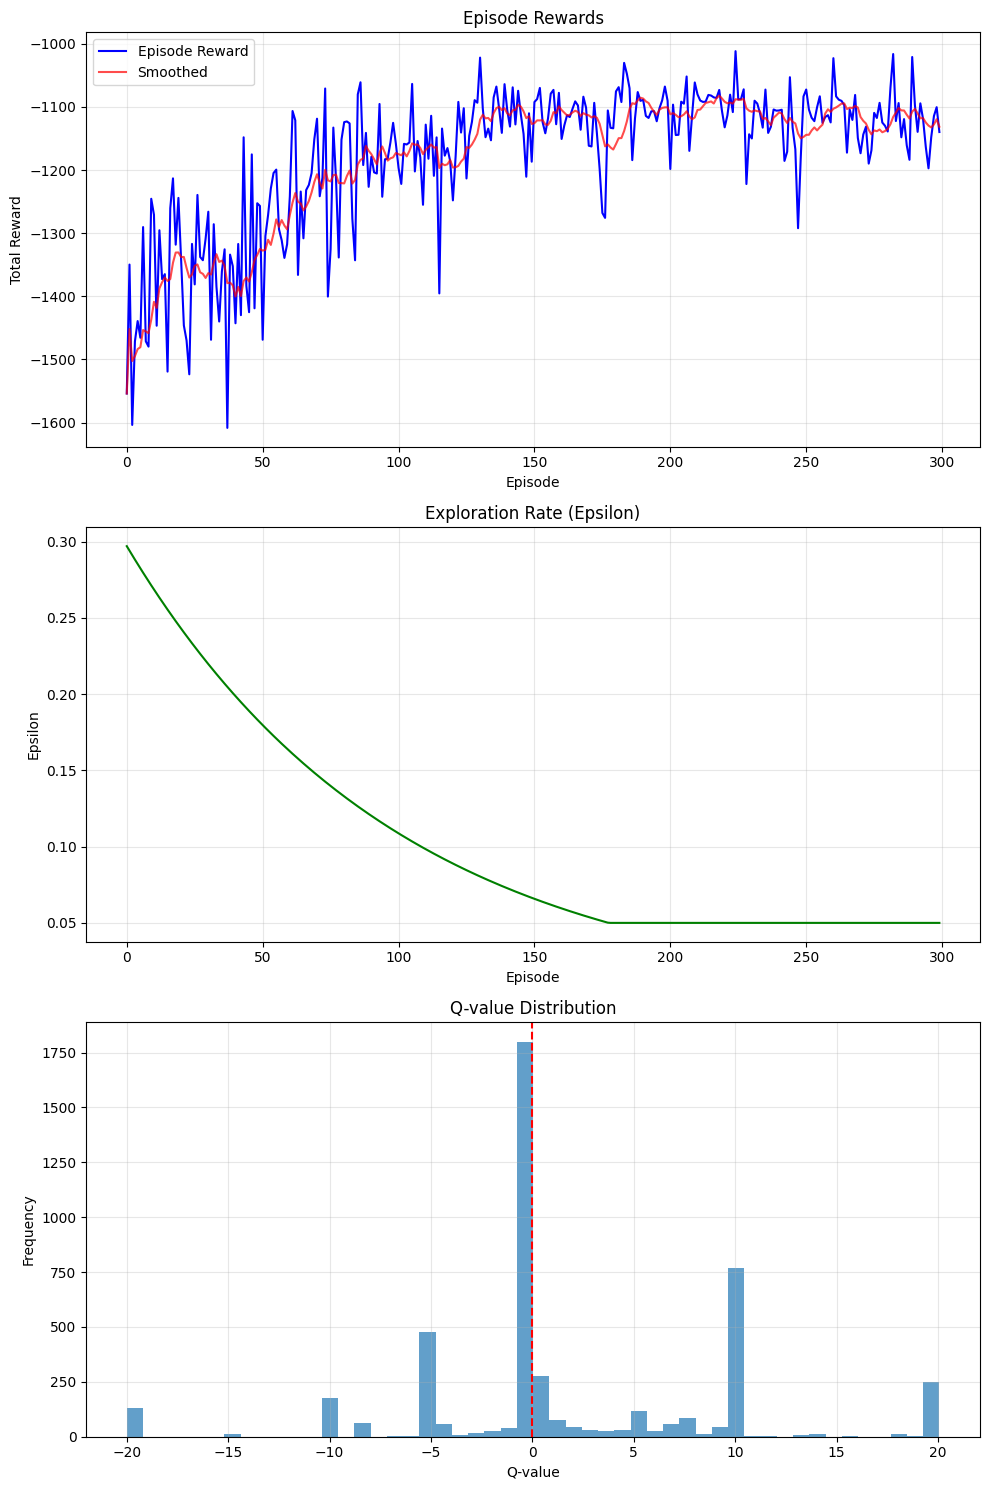


Starting evaluation phase with the best model...
Initializing Q-table with guided values...
Q-table initialization complete.


In [ ]:

def main():
  
    episodes = 300   
    eval_steps = 200  
    

    print("\nLoading data...")
    try:
        data = load_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Proceeding with empty data - will use simulated data.")
        data = {}
    
 
    print("\nInitializing environment...")
    env = CloudEnvironment(data)
    
  
    print("\nInitializing Q-learning agent for training...")
    agent = QAgent(bins_per_dim=BINS_PER_DIM)
    


if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error in main: {e}")
        import traceback
        traceback.print_exc()